In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('data/new-york-taxi-fare-prediction/train.csv', nrows=50000)

# Remove data with extreme outlier coordinates or negative fares
data = data.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0'
                  )
y = data.fare_amount

base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude']

X = data[base_features]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
first_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(train_X, train_y)


In [4]:
print("Data sample:")
data.sample(2)

Data sample:


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
8670,2013-05-06 20:42:44.0000001,6.5,2013-05-06 20:42:44 UTC,-73.989064,40.758661,-73.984974,40.748410,1
25267,2010-09-14 13:36:00.000000163,13.3,2010-09-14 13:36:00 UTC,-73.990030,40.738518,-73.982318,40.768152,1


In [5]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000
mean,8.483093,-73.976860,40.756917,-73.975342,40.757473,1.656141
std,4.628164,0.014635,0.018170,0.015917,0.018661,1.284899
min,0.010000,-73.999999,40.700013,-73.999999,40.700020,0.000000
25%,5.500000,-73.988039,40.744947,-73.987125,40.745922,1.000000
50%,7.500000,-73.979691,40.758027,-73.978547,40.758559,1.000000
75%,10.100000,-73.967823,40.769580,-73.966435,40.770427,2.000000
max,165.000000,-73.900062,40.799952,-73.900062,40.799999,6.000000


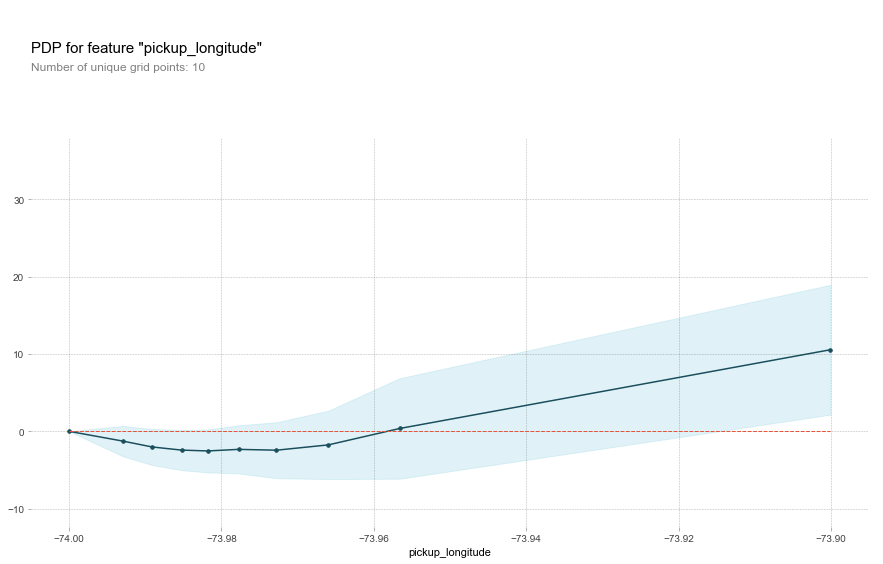

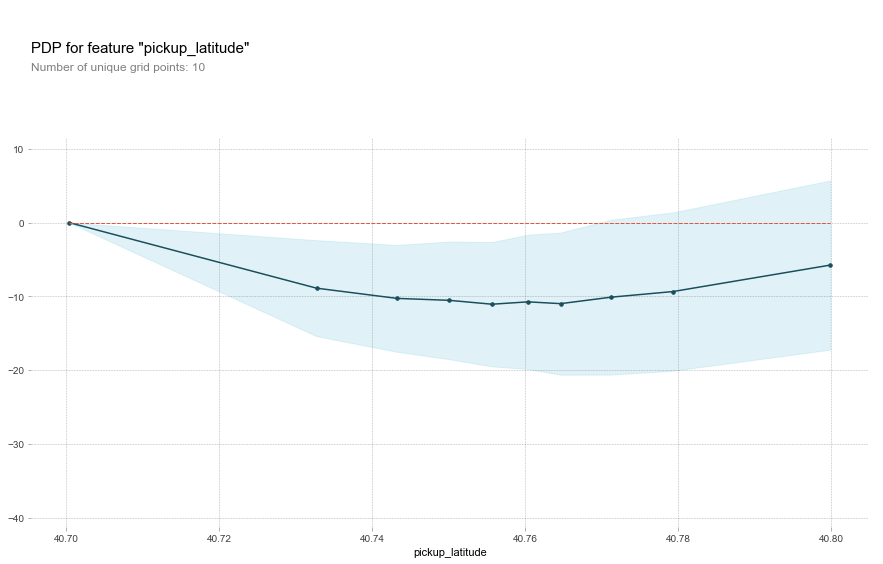

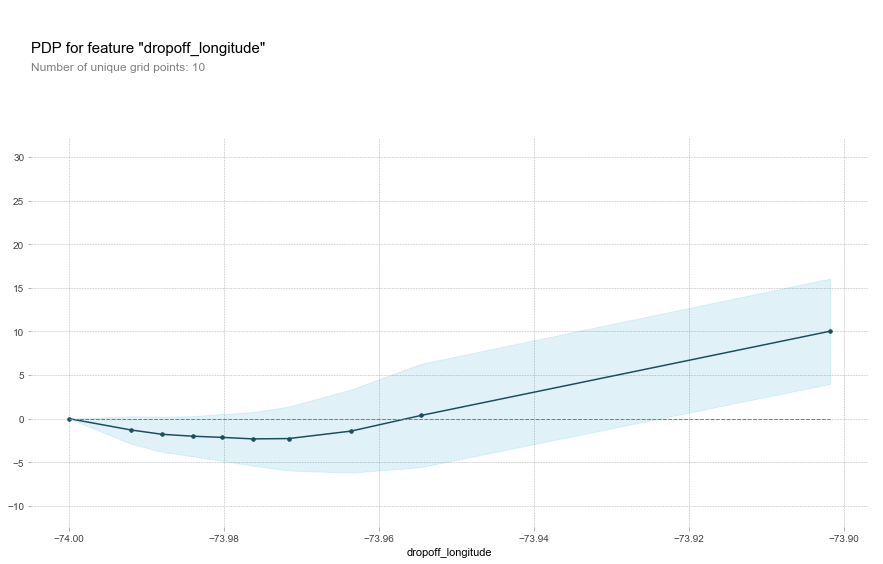

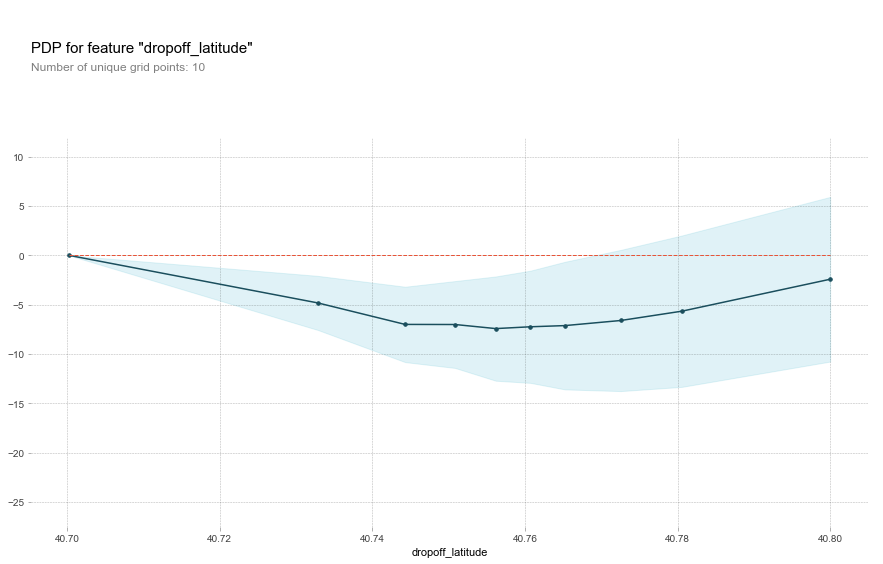

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

from pdpbox import pdp, get_dataset, info_plots

base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude']
for feat_name in base_features:
    pdp_dist = pdp.pdp_isolate(model=first_model, dataset=val_X, model_features=base_features, feature=feat_name)
    pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

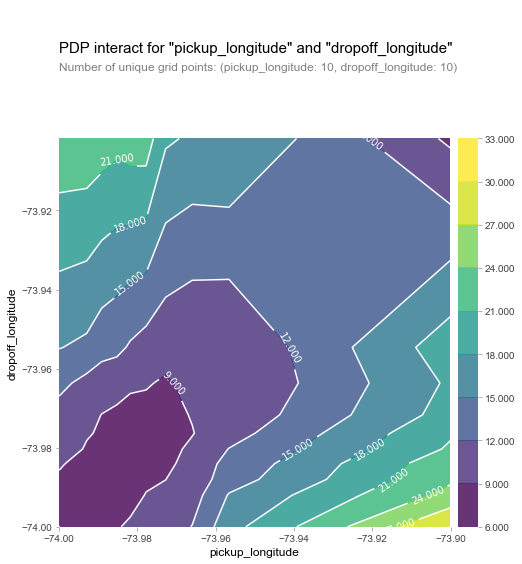

In [7]:
features_to_plot = ['pickup_longitude', 'dropoff_longitude']
inter1  =  pdp.pdp_interact(model=first_model, dataset=val_X, model_features=base_features, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

#### Question
Consider a ride starting at longitude -73.92 and ending at longitude -74. Using the graph from the last question, estimate how much money the rider would have saved if they'd started the ride at longitude -73.98 instead?

The price decreases from slightly more than 24 to slightly more than 9.

In [10]:
data['abs_lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude)
data['abs_lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)

features_2  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']

X = data[features_2]
new_train_X, new_val_X, new_train_y, new_val_y = train_test_split(X, y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(new_train_X, new_train_y)


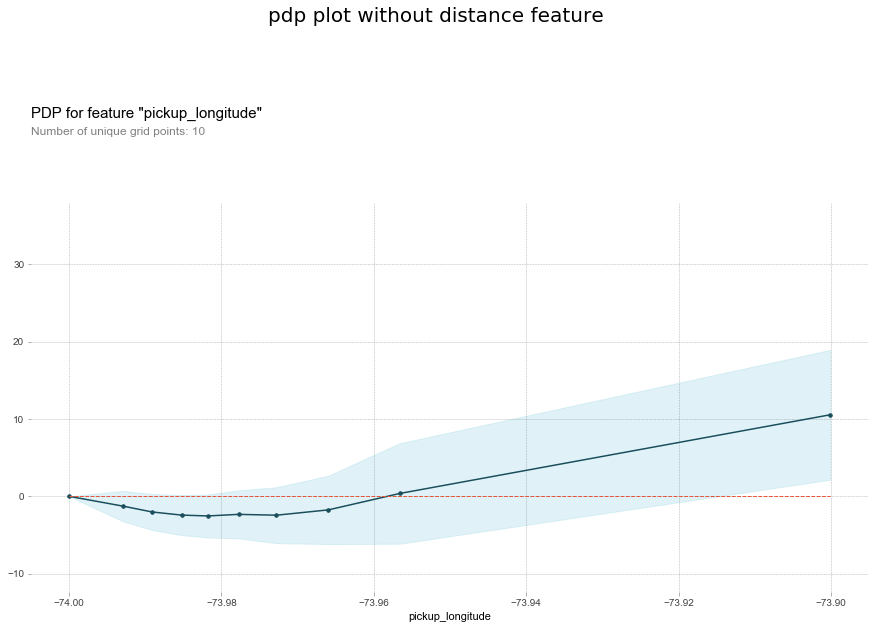

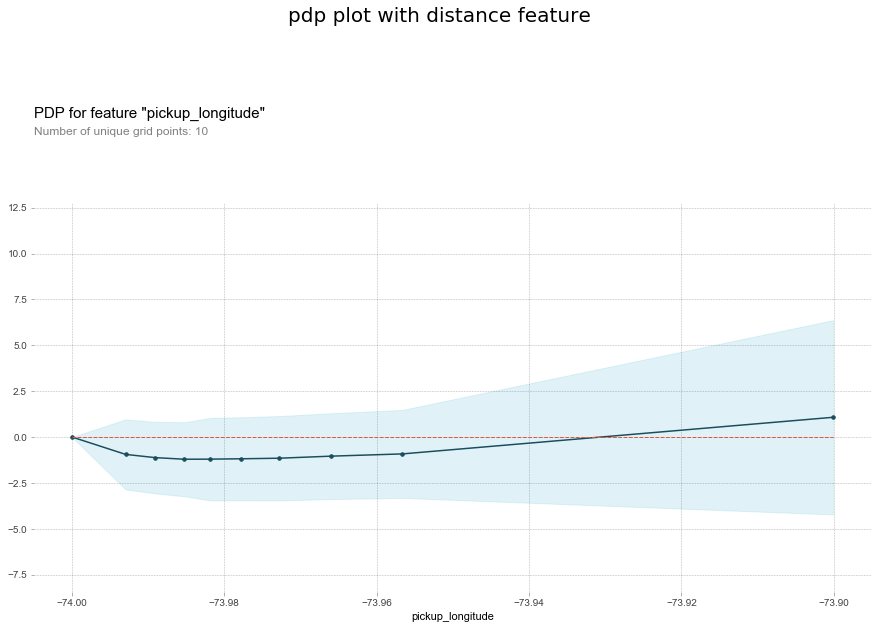

In [21]:
feat_name = 'pickup_longitude'

pdp_dist_original = pdp.pdp_isolate(model=first_model, dataset=val_X, model_features=base_features, feature=feat_name)

fig, _ = pdp.pdp_plot(pdp_dist_original, feat_name)
fig.suptitle('pdp plot without distance feature', fontsize=20)
plt.show()

pdp_dist = pdp.pdp_isolate(model=second_model, dataset=new_val_X, model_features=features_2, feature=feat_name)
fig, _ = pdp.pdp_plot(pdp_dist, feat_name)
fig.suptitle('pdp plot with distance feature', fontsize=20)

plt.show()

#### Difference between plot with distance added
The pickup longitude has a much smaller impact once the distance feature is added. In the first plot, the value varies from about -2 to 10. In the second plot, this is only  -1 to 1. Also, the second pdp plot increases at a slower rate.

### Question
Consider a scenario where you have only 2 predictive features, which we will call `feat_A` and `feat_B`. Both features have minimum values of -1 and maximum values of 1.  The partial dependence plot for `feat_A` increases steeply over its whole range, whereas the partial dependence plot for feature B increases at a slower rate (less steeply) over its whole range.

Does this guarantee that `feat_A` will have a higher permutation importance than `feat_B`.  Why or why not?

### Answer
No. This doesn't guarantee feat_a is more important. For example, feat_a could have a big effect in the cases where it varies, but could have a single value 99% of the time. In that case, permuting feat_a wouldn't matter much, since most values would be unchanged.

1.6925895365774193


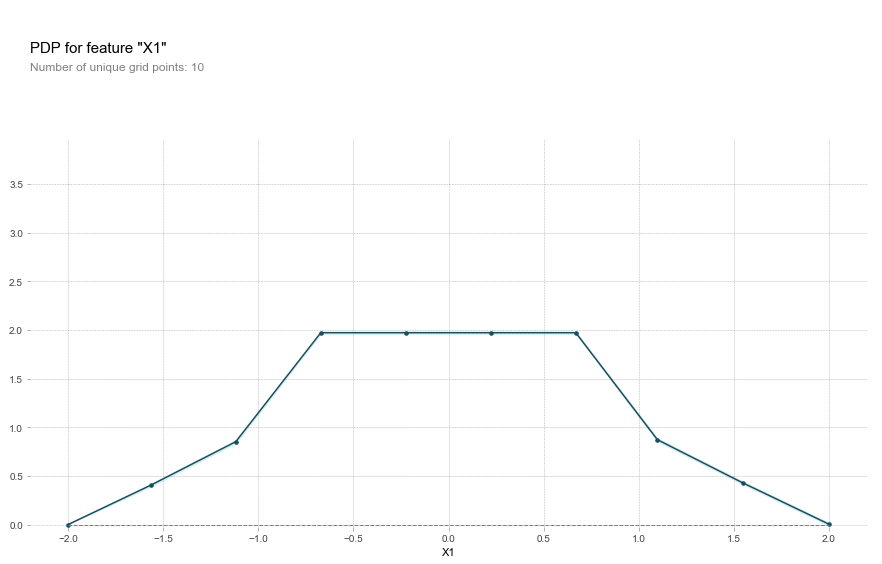

In [39]:
import numpy as np
from numpy.random import rand

n_samples = 20000

# Create array holding predictive feature
X1 = 4 * rand(n_samples) - 2
X2 = 4 * rand(n_samples) - 2


# Create y. you should have X1 and X2 in the expression for y
#y = -2 * X1 * (X1<-1) + X1 - 2 * X1 * (X1>1) - X2
y = X1 * (X1<-1) - X1 * (X1>1) - X2
print(y[19999])
# create dataframe because pdp_isolate expects a dataFrame as an argument
my_df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
predictors_df = my_df.drop(['y'], axis=1)

my_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(predictors_df, my_df.y)

pdp_dist = pdp.pdp_isolate(model=my_model, dataset=my_df, model_features=['X1', 'X2'], feature='X1')
pdp.pdp_plot(pdp_dist, 'X1')
plt.show()

### Further reading
sklearn provides a good documentation, too:
PDP will be available for other models as well in future releases of sklearn.
http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html
